# Twitter 2018

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')  # Download the VADER lexicon
import matplotlib.pyplot as plt

import psycopg2
from sqlalchemy import create_engine

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Extract and organize data

In [2]:
# import data
data = pd.read_csv('Twitter/result20180101-20190101.csv',encoding='ISO-8859-1')


In [3]:
# grab fields of interest
# select the columns wanted and rename them
df_selection = data[['create_at', 'geo_tag.stateName', 'user.id', 'text']]
data = df_selection.rename(columns={
    'create_at': 'Created',
    'geo_tag.stateName': 'State',
    'user.id': 'Owner',
    'text': 'Tweet'
})
data
# gives 12653 rows × 4 columns

,Created,State,Owner,Tweet
0,2018-12-01 01:00:48.0,Oklahoma,930134408,"So clearly, the @GOP in #Oklahoma did not get ..."
1,2018-12-01 06:26:11.0,California,48243245,@jimmy_dore @miserablelib @RonPlacone im glad ...
2,2018-12-01 15:13:45.0,Michigan,948344223937515520,@DeepStateExpose @helloDolly00 And his job is ...
3,2018-12-01 17:28:54.0,Indiana,158216203,Another aside from this @davidmackau story: \n...
4,2018-12-01 21:41:00.0,Colorado,13241522,If we keep calling Bush a war criminal (19m hi...
...,...,...,...,...
12648,2018-11-30 13:07:29.0,Georgia,67097788,@underHiswing914 @thedjrichyb @VABVOX @realDon...
12649,2018-11-30 17:14:15.0,California,734499500862115841,@bAbAHAdAd @GENIC0N It's also funny that you t...
12650,2018-11-30 18:22:23.0,California,803988972061896704,@johnsonkevinb @cspanwj Criminal regime this ...
12651,2018-11-30 20:23:40.0,California,762782904669777920,"@orangecakemix @realDonaldTrump The ""Teflon Qu..."


In [4]:
# convert the states to abbrivations
state_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# Apply the state mapping to convert the state column
data['State'] = data['State'].map(state_mapping)

# Print the updated DataFrame
data

,Created,State,Owner,Tweet
0,2018-12-01 01:00:48.0,OK,930134408,"So clearly, the @GOP in #Oklahoma did not get ..."
1,2018-12-01 06:26:11.0,CA,48243245,@jimmy_dore @miserablelib @RonPlacone im glad ...
2,2018-12-01 15:13:45.0,MI,948344223937515520,@DeepStateExpose @helloDolly00 And his job is ...
3,2018-12-01 17:28:54.0,IN,158216203,Another aside from this @davidmackau story: \n...
4,2018-12-01 21:41:00.0,CO,13241522,If we keep calling Bush a war criminal (19m hi...
...,...,...,...,...
12648,2018-11-30 13:07:29.0,GA,67097788,@underHiswing914 @thedjrichyb @VABVOX @realDon...
12649,2018-11-30 17:14:15.0,CA,734499500862115841,@bAbAHAdAd @GENIC0N It's also funny that you t...
12650,2018-11-30 18:22:23.0,CA,803988972061896704,@johnsonkevinb @cspanwj Criminal regime this ...
12651,2018-11-30 20:23:40.0,CA,762782904669777920,"@orangecakemix @realDonaldTrump The ""Teflon Qu..."


In [5]:
# add year and office columns
data['Year'] = 2018
# Arrange columns: Move the Year and Office columns to the front
new_cols = ['Year', 'Created', 'State', 'Owner', 'Tweet']
data_2018 = data.reindex(columns=new_cols)
data_2018
# gives 5608

,Year,Created,State,Owner,Tweet
0,2018,2018-12-01 01:00:48.0,OK,930134408,"So clearly, the @GOP in #Oklahoma did not get ..."
1,2018,2018-12-01 06:26:11.0,CA,48243245,@jimmy_dore @miserablelib @RonPlacone im glad ...
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,@DeepStateExpose @helloDolly00 And his job is ...
3,2018,2018-12-01 17:28:54.0,IN,158216203,Another aside from this @davidmackau story: \n...
4,2018,2018-12-01 21:41:00.0,CO,13241522,If we keep calling Bush a war criminal (19m hi...
...,...,...,...,...,...
12648,2018,2018-11-30 13:07:29.0,GA,67097788,@underHiswing914 @thedjrichyb @VABVOX @realDon...
12649,2018,2018-11-30 17:14:15.0,CA,734499500862115841,@bAbAHAdAd @GENIC0N It's also funny that you t...
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,@johnsonkevinb @cspanwj Criminal regime this ...
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,"@orangecakemix @realDonaldTrump The ""Teflon Qu..."


In [6]:
# Check for duplicate rows
duplicate_rows = data_2018.duplicated()

# Print the duplicate rows
print(data_2018[duplicate_rows])

       Year                Created State               Owner   
302    2018  2018-12-07 04:40:17.0    CA           805224049  \
305    2018  2018-12-09 04:42:27.0    CA           515098734   
331    2018  2018-12-09 21:31:25.0    NJ            18355637   
369    2018  2018-12-10 23:28:52.0    FL          3358247374   
391    2018  2018-12-11 22:19:19.0    FL           475499381   
...     ...                    ...   ...                 ...   
12584  2018  2018-11-21 23:00:22.0    CA            41380137   
12595  2018  2018-11-24 03:23:24.0    CA            23278492   
12607  2018  2018-11-26 01:06:50.0    PA  929804763398656000   
12623  2018  2018-11-27 16:00:22.0    VA          2744927166   
12649  2018  2018-11-30 17:14:15.0    CA  734499500862115841   

                                                   Tweet  
302    @SoCalEdgyGal No; just enforce immigration law...  
305    @sltrib @RichLowry Election fraud not voter fr...  
331    Yellow Vest Demands\n1. Election integrity\n2..

In [7]:
# Remove duplicate rows
data_2018 = data_2018.drop_duplicates()

# Print the DataFrame without duplicates
data_2018
# gives 12010 rows × 5 columns

,Year,Created,State,Owner,Tweet
0,2018,2018-12-01 01:00:48.0,OK,930134408,"So clearly, the @GOP in #Oklahoma did not get ..."
1,2018,2018-12-01 06:26:11.0,CA,48243245,@jimmy_dore @miserablelib @RonPlacone im glad ...
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,@DeepStateExpose @helloDolly00 And his job is ...
3,2018,2018-12-01 17:28:54.0,IN,158216203,Another aside from this @davidmackau story: \n...
4,2018,2018-12-01 21:41:00.0,CO,13241522,If we keep calling Bush a war criminal (19m hi...
...,...,...,...,...,...
12647,2018,2018-11-30 06:35:58.0,OH,625159168,@ODPP_KE when will you prosecute election tamp...
12648,2018,2018-11-30 13:07:29.0,GA,67097788,@underHiswing914 @thedjrichyb @VABVOX @realDon...
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,@johnsonkevinb @cspanwj Criminal regime this ...
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,"@orangecakemix @realDonaldTrump The ""Teflon Qu..."


# Clean and process data

In [8]:
def trim_length(text):
    '''
    This method removes the repeating characters that are repeated more than 2 times
    '''
    pat = re.compile(r"(.)\1{2,}")
    return pat.sub(r"\1\1", text)

def word_correct(myStr):
    '''
    This method accepts a string and removes the meta characters from it
    '''
    myStr = str(myStr)
    pat = re.compile(r'[^a-zA-Z1-9]+')
    corrected_str = ''
    splits = myStr.split()
    for word in splits:
        word = word.strip()
        word = re.sub(pat, '', word).lower()
        word = trim_length(word)
        corrected_str = corrected_str+word+' '
    corrected_str = corrected_str.strip()
    return corrected_str

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_word(myStr):
    myStr = str(myStr)
    lemmatizer = WordNetLemmatizer()
    lst_word = nltk.word_tokenize(myStr)
    final_str=''
    for word in lst_word:
        word = lemmatizer.lemmatize(word, get_pos(word))
        final_str = final_str+word+' '

    final_str = final_str.strip()
    return final_str

data_2018['Tweet'] = data_2018['Tweet'].apply(lambda i:word_correct(i))
data_2018['Tweet'] = data_2018['Tweet'].apply(lambda i:lemmatize_word(i))
print('Done')

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\2723966737.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['Tweet'] = data_2018['Tweet'].apply(lambda i:word_correct(i))


Done


C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\2723966737.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2018['Tweet'] = data_2018['Tweet'].apply(lambda i:lemmatize_word(i))


In [9]:
# view cleaned data
data_2018

,Year,Created,State,Owner,Tweet
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...
1,2018,2018-12-01 06:26:11.0,CA,48243245,jimmydore miserablelib ronplacone im glad his ...
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...
3,2018,2018-12-01 17:28:54.0,IN,158216203,another aside from this davidmackau story im s...
4,2018,2018-12-01 21:41:00.0,CO,13241522,if we keep call bush a war criminal 19m hit on...
...,...,...,...,...,...
12647,2018,2018-11-30 06:35:58.0,OH,625159168,odppke when will you prosecute election tamper...
12648,2018,2018-11-30 13:07:29.0,GA,67097788,underhiswing914 thedjrichyb vabvox realdonaldt...
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,johnsonkevinb cspanwj criminal regime this be ...
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,orangecakemix realdonaldtrump the teflon queen...


# Abortion Tweets

In [10]:
def extract_abortion_text(df):
    df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)
    return df

abortion_tweet_2018 = extract_abortion_text(data_2018)
abortion_tweet_2018

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\2264525002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Abortion'] = df['Tweet'].str.extract(r'(\b(?:abortion|planned|parenthood|prochoice|pro-choice|prolife|pro-life|reproductiverights|reproductive-rights|right|choose|women\'s|rights|termination|roe|wade|pro-abortion|anti-abortion|fetus|pregnancy|reproductive|healthcare|health|access|ban|debate)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion
1,2018,2018-12-01 06:26:11.0,CA,48243245,jimmydore miserablelib ronplacone im glad his ...,NaN
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN
3,2018,2018-12-01 17:28:54.0,IN,158216203,another aside from this davidmackau story im s...,NaN
4,2018,2018-12-01 21:41:00.0,CO,13241522,if we keep call bush a war criminal 19m hit on...,NaN
...,...,...,...,...,...,...
12647,2018,2018-11-30 06:35:58.0,OH,625159168,odppke when will you prosecute election tamper...,NaN
12648,2018,2018-11-30 13:07:29.0,GA,67097788,underhiswing914 thedjrichyb vabvox realdonaldt...,NaN
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,johnsonkevinb cspanwj criminal regime this be ...,NaN
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,orangecakemix realdonaldtrump the teflon queen...,NaN


In [11]:
# remove NaN rows
abortion_2018 = abortion_tweet_2018[abortion_tweet_2018['Abortion'].notna()]
abortion_2018
# gives 1379 rows × 6 columns

,Year,Created,State,Owner,Tweet,Abortion
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion
86,2018,2018-12-10 13:01:00.0,NY,49430708,realdonaldtrump foxnews and they have you dead...,right
118,2018,2018-12-12 23:36:24.0,NY,28327349,4 job climate change action gun control hand o...,abortion
132,2018,2018-12-14 17:38:48.0,VA,3361551916,neeratanden how would the election have change...,access
137,2018,2018-12-15 02:20:48.0,MO,1011382316172578816,regimechangeinc ddiamond obama make the mistak...,health
...,...,...,...,...,...,...
12615,2018,2018-11-26 16:50:54.0,CA,771795931637379072,liz peek hillary clinton do it again dems not ...,right
12617,2018,2018-11-26 19:41:01.0,CA,245100423,thevictorgallo coastalwoman56 whatever not sur...,right
12627,2018,2018-11-28 00:40:55.0,CA,1573107234,realdonaldtrump disastrous tariff gm layoff an...,right
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,right


# Feed cleaned data into VADER algo

In [13]:
# only positive and negative sentiments
def get_sentiment_scores(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' and 'compound' columns from the SentimentScores column
    df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})
    
    return df

In [14]:
# Call sentiment function
abortion_sent_2018 = get_sentiment_scores(abortion_2018)
abortion_sent_2018

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,SentimentScores
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,"{'neg': 0.0, 'pos': 0.186}"
86,2018,2018-12-10 13:01:00.0,NY,49430708,realdonaldtrump foxnews and they have you dead...,right,"{'neg': 0.428, 'pos': 0.048}"
118,2018,2018-12-12 23:36:24.0,NY,28327349,4 job climate change action gun control hand o...,abortion,"{'neg': 0.141, 'pos': 0.115}"
132,2018,2018-12-14 17:38:48.0,VA,3361551916,neeratanden how would the election have change...,access,"{'neg': 0.215, 'pos': 0.0}"
137,2018,2018-12-15 02:20:48.0,MO,1011382316172578816,regimechangeinc ddiamond obama make the mistak...,health,"{'neg': 0.098, 'pos': 0.108}"
...,...,...,...,...,...,...,...
12615,2018,2018-11-26 16:50:54.0,CA,771795931637379072,liz peek hillary clinton do it again dems not ...,right,"{'neg': 0.119, 'pos': 0.0}"
12617,2018,2018-11-26 19:41:01.0,CA,245100423,thevictorgallo coastalwoman56 whatever not sur...,right,"{'neg': 0.239, 'pos': 0.039}"
12627,2018,2018-11-28 00:40:55.0,CA,1573107234,realdonaldtrump disastrous tariff gm layoff an...,right,"{'neg': 0.212, 'pos': 0.116}"
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,right,"{'neg': 0.377, 'pos': 0.0}"


In [15]:
# show values
abortion_sent_2018['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        73
{'neg': 0.16, 'pos': 0.0}        8
{'neg': 0.091, 'pos': 0.0}       5
{'neg': 0.099, 'pos': 0.0}       4
{'neg': 0.0, 'pos': 0.148}       4
                                ..
{'neg': 0.126, 'pos': 0.216}     1
{'neg': 0.112, 'pos': 0.197}     1
{'neg': 0.093, 'pos': 0.146}     1
{'neg': 0.293, 'pos': 0.0}       1
{'neg': 0.09, 'pos': 0.241}      1
Name: count, Length: 1150, dtype: int64

In [16]:
# Extract the sentiment scores from the 'SentimentScores' column
abortion_sent_2018['Norm_Neg'] = abortion_sent_2018['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2018['Norm_Pos'] = abortion_sent_2018['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
abortion_sent_2018
# gives 1379 rows × 9 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\3370219396.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2018['Norm_Neg'] = abortion_sent_2018['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\3370219396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abortion_sent_2018['Norm_Pos'] = abortion_sent_2018['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['n

,Year,Created,State,Owner,Tweet,Abortion,SentimentScores,Norm_Neg,Norm_Pos
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,"{'neg': 0.0, 'pos': 0.186}",0.000000,1.000000
86,2018,2018-12-10 13:01:00.0,NY,49430708,realdonaldtrump foxnews and they have you dead...,right,"{'neg': 0.428, 'pos': 0.048}",0.899160,0.100840
118,2018,2018-12-12 23:36:24.0,NY,28327349,4 job climate change action gun control hand o...,abortion,"{'neg': 0.141, 'pos': 0.115}",0.550781,0.449219
132,2018,2018-12-14 17:38:48.0,VA,3361551916,neeratanden how would the election have change...,access,"{'neg': 0.215, 'pos': 0.0}",1.000000,0.000000
137,2018,2018-12-15 02:20:48.0,MO,1011382316172578816,regimechangeinc ddiamond obama make the mistak...,health,"{'neg': 0.098, 'pos': 0.108}",0.475728,0.524272
...,...,...,...,...,...,...,...,...,...
12615,2018,2018-11-26 16:50:54.0,CA,771795931637379072,liz peek hillary clinton do it again dems not ...,right,"{'neg': 0.119, 'pos': 0.0}",1.000000,0.000000
12617,2018,2018-11-26 19:41:01.0,CA,245100423,thevictorgallo coastalwoman56 whatever not sur...,right,"{'neg': 0.239, 'pos': 0.039}",0.859712,0.140288
12627,2018,2018-11-28 00:40:55.0,CA,1573107234,realdonaldtrump disastrous tariff gm layoff an...,right,"{'neg': 0.212, 'pos': 0.116}",0.646341,0.353659
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,right,"{'neg': 0.377, 'pos': 0.0}",1.000000,0.000000


# Race Tweets

In [17]:
def extract_race_text(df):
    df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE) 
    return df

# call race function
# note data_2018 will hold all columns with NaN's
race_tweet_2018 = extract_race_text(data_2018)
race_tweet_2018

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\2886804317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Race'] = df['Tweet'].str.extract(r'(\b(?:racism|discrimination|equality|racial|ethnic|bias|prejudice|injustice|diversity|race|white|privilege|BLM|black|lives|matter|systemic|social|justice|sterotype|oppression|minority|segregation|multiculturalism|colorism|civil|rights|profiling|cultrual|appropriation|affirmative|action|intersectionality|institutional|discrimination|implicit)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN
1,2018,2018-12-01 06:26:11.0,CA,48243245,jimmydore miserablelib ronplacone im glad his ...,NaN,NaN
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice
3,2018,2018-12-01 17:28:54.0,IN,158216203,another aside from this davidmackau story im s...,NaN,NaN
4,2018,2018-12-01 21:41:00.0,CO,13241522,if we keep call bush a war criminal 19m hit on...,NaN,NaN
...,...,...,...,...,...,...,...
12647,2018,2018-11-30 06:35:58.0,OH,625159168,odppke when will you prosecute election tamper...,NaN,NaN
12648,2018,2018-11-30 13:07:29.0,GA,67097788,underhiswing914 thedjrichyb vabvox realdonaldt...,NaN,NaN
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,johnsonkevinb cspanwj criminal regime this be ...,NaN,NaN
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,orangecakemix realdonaldtrump the teflon queen...,NaN,NaN


In [18]:
race_2018 = race_tweet_2018[race_tweet_2018['Race'].notna()]
# Drop Abortion column
race_2018 = race_2018.drop('Abortion', axis=1)
race_2018
# gives 534 rows

,Year,Created,State,Owner,Tweet,Race
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,justice
25,2018,2018-12-04 22:48:27.0,FL,1395145724,a good year one abusive ex die in hurricaneflo...,segregation
29,2018,2018-12-05 14:29:45.0,MO,2159907348,baesparza kathleenhbeach moi i recognize white...,white
30,2018,2018-12-05 19:14:01.0,WI,886239052936163330,h2obeth jessieopie tony4wi not if we kick out ...,white
34,2018,2018-12-06 15:07:54.0,KS,710462346351673344,jessicavcis anncoulter massgovernor ann this b...,action
...,...,...,...,...,...,...
12624,2018,2018-11-27 18:19:09.0,FL,2229651353,chuckcallesto dems turn dn daca deal no compas...,black
12628,2018,2018-11-28 03:38:02.0,MA,1048032835,senatorcollins congrats susan your colleague a...,segregation
12630,2018,2018-11-28 09:17:06.0,NY,19432322,ericholder huh what blue wave obama lose 63 du...,justice
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,civil


In [19]:
# run Vader sentiment on race tweets
race_sent_2018 = get_sentiment_scores(race_2018)
race_sent_2018

,Year,Created,State,Owner,Tweet,Race,SentimentScores
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,justice,"{'neg': 0.156, 'pos': 0.15}"
25,2018,2018-12-04 22:48:27.0,FL,1395145724,a good year one abusive ex die in hurricaneflo...,segregation,"{'neg': 0.214, 'pos': 0.133}"
29,2018,2018-12-05 14:29:45.0,MO,2159907348,baesparza kathleenhbeach moi i recognize white...,white,"{'neg': 0.173, 'pos': 0.15}"
30,2018,2018-12-05 19:14:01.0,WI,886239052936163330,h2obeth jessieopie tony4wi not if we kick out ...,white,"{'neg': 0.1, 'pos': 0.061}"
34,2018,2018-12-06 15:07:54.0,KS,710462346351673344,jessicavcis anncoulter massgovernor ann this b...,action,"{'neg': 0.171, 'pos': 0.063}"
...,...,...,...,...,...,...,...
12624,2018,2018-11-27 18:19:09.0,FL,2229651353,chuckcallesto dems turn dn daca deal no compas...,black,"{'neg': 0.174, 'pos': 0.185}"
12628,2018,2018-11-28 03:38:02.0,MA,1048032835,senatorcollins congrats susan your colleague a...,segregation,"{'neg': 0.0, 'pos': 0.262}"
12630,2018,2018-11-28 09:17:06.0,NY,19432322,ericholder huh what blue wave obama lose 63 du...,justice,"{'neg': 0.104, 'pos': 0.184}"
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,civil,"{'neg': 0.377, 'pos': 0.0}"


In [20]:
# count race sentiment scores
race_2018['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        62
{'neg': 0.112, 'pos': 0.188}    11
{'neg': 0.115, 'pos': 0.193}     9
{'neg': 0.07, 'pos': 0.119}      8
{'neg': 0.261, 'pos': 0.111}     8
                                ..
{'neg': 0.192, 'pos': 0.21}      1
{'neg': 0.205, 'pos': 0.125}     1
{'neg': 0.0, 'pos': 0.052}       1
{'neg': 0.079, 'pos': 0.233}     1
{'neg': 0.127, 'pos': 0.348}     1
Name: count, Length: 1560, dtype: int64

In [21]:
# Extract the sentiment scores from the 'SentimentScores' column
race_sent_2018['Norm_Neg'] = race_sent_2018['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2018['Norm_Pos'] = race_sent_2018['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
race_sent_2018.head()

,Year,Created,State,Owner,Tweet,Race,SentimentScores,Norm_Neg,Norm_Pos
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,justice,"{'neg': 0.156, 'pos': 0.15}",0.509804,0.490196
25,2018,2018-12-04 22:48:27.0,FL,1395145724,a good year one abusive ex die in hurricaneflo...,segregation,"{'neg': 0.214, 'pos': 0.133}",0.616715,0.383285
29,2018,2018-12-05 14:29:45.0,MO,2159907348,baesparza kathleenhbeach moi i recognize white...,white,"{'neg': 0.173, 'pos': 0.15}",0.535604,0.464396
30,2018,2018-12-05 19:14:01.0,WI,886239052936163330,h2obeth jessieopie tony4wi not if we kick out ...,white,"{'neg': 0.1, 'pos': 0.061}",0.621118,0.378882
34,2018,2018-12-06 15:07:54.0,KS,710462346351673344,jessicavcis anncoulter massgovernor ann this b...,action,"{'neg': 0.171, 'pos': 0.063}",0.730769,0.269231


# Immigration Tweets

In [22]:
def extract_immigration_text(df):
    df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)
    return df

immigration_tweet_2018 = extract_immigration_text(data_2018)
immigration_tweet_2018

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\1538533491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Immigration'] = df['Tweet'].str.extract(r'(\b(?:immigration|refugees|border|undocumented|nationalism|xenophobia|dreamers|asylum|seekers|migration|deportation|citizenship|control|illegal|policy|reform|visa|integration|assimilation|sanctuary|family|separation|humanitarian|immigrant|rights|gloal|migration)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN,NaN
1,2018,2018-12-01 06:26:11.0,CA,48243245,jimmydore miserablelib ronplacone im glad his ...,NaN,NaN,NaN
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice,NaN
3,2018,2018-12-01 17:28:54.0,IN,158216203,another aside from this davidmackau story im s...,NaN,NaN,NaN
4,2018,2018-12-01 21:41:00.0,CO,13241522,if we keep call bush a war criminal 19m hit on...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12647,2018,2018-11-30 06:35:58.0,OH,625159168,odppke when will you prosecute election tamper...,NaN,NaN,NaN
12648,2018,2018-11-30 13:07:29.0,GA,67097788,underhiswing914 thedjrichyb vabvox realdonaldt...,NaN,NaN,NaN
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,johnsonkevinb cspanwj criminal regime this be ...,NaN,NaN,NaN
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,orangecakemix realdonaldtrump the teflon queen...,NaN,NaN,NaN


In [23]:
immigration_2018 = immigration_tweet_2018[immigration_tweet_2018['Immigration'].notna()]
# Drop Abortion and Race columns
immigration_2018 = immigration_2018.drop(['Abortion', 'Race'], axis=1)
immigration_2018
# gives 3230 rows × 6 columns

,Year,Created,State,Owner,Tweet,Immigration
8,2018,2018-12-02 16:39:10.0,FL,594050440,kayleighmcenany realdonaldtrump dailycaller th...,border
9,2018,2018-12-02 18:18:02.0,TX,729745131918626817,thetrumptrain i think we have a real voting in...,illegal
11,2018,2018-12-03 00:52:29.0,WA,2440550286,fairimmigration let start with make trump sit ...,control
13,2018,2018-12-03 13:33:22.0,CT,861207654,foxandfriends talk to caravan expert shepnewst...,immigrant
16,2018,2018-12-03 23:48:34.0,CA,14197307,realdonaldtrump hey donald the gop nc9th distr...,illegal
...,...,...,...,...,...,...
12625,2018,2018-11-27 19:39:29.0,FL,1001659074851889153,vp hillaryclinton barackobama potus if you bot...,border
12627,2018,2018-11-28 00:40:55.0,CA,1573107234,realdonaldtrump disastrous tariff gm layoff an...,border
12629,2018,2018-11-28 06:02:19.0,CA,3229802804,agniworks repbarbaralee un ex ag jeff session ...,illegal
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,border


In [24]:
# run Vader sentiment on immigration tweets
immigration_sent_2018 = get_sentiment_scores(immigration_2018)
immigration_sent_2018

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores
8,2018,2018-12-02 16:39:10.0,FL,594050440,kayleighmcenany realdonaldtrump dailycaller th...,border,"{'neg': 0.047, 'pos': 0.186}"
9,2018,2018-12-02 18:18:02.0,TX,729745131918626817,thetrumptrain i think we have a real voting in...,illegal,"{'neg': 0.316, 'pos': 0.049}"
11,2018,2018-12-03 00:52:29.0,WA,2440550286,fairimmigration let start with make trump sit ...,control,"{'neg': 0.19, 'pos': 0.063}"
13,2018,2018-12-03 13:33:22.0,CT,861207654,foxandfriends talk to caravan expert shepnewst...,immigrant,"{'neg': 0.322, 'pos': 0.127}"
16,2018,2018-12-03 23:48:34.0,CA,14197307,realdonaldtrump hey donald the gop nc9th distr...,illegal,"{'neg': 0.282, 'pos': 0.05}"
...,...,...,...,...,...,...,...
12625,2018,2018-11-27 19:39:29.0,FL,1001659074851889153,vp hillaryclinton barackobama potus if you bot...,border,"{'neg': 0.075, 'pos': 0.334}"
12627,2018,2018-11-28 00:40:55.0,CA,1573107234,realdonaldtrump disastrous tariff gm layoff an...,border,"{'neg': 0.212, 'pos': 0.116}"
12629,2018,2018-11-28 06:02:19.0,CA,3229802804,agniworks repbarbaralee un ex ag jeff session ...,illegal,"{'neg': 0.079, 'pos': 0.0}"
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,border,"{'neg': 0.09, 'pos': 0.241}"


In [25]:
# count immigration sentiment scores
immigration_sent_2018['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        156
{'neg': 0.117, 'pos': 0.051}     31
{'neg': 0.115, 'pos': 0.05}      20
{'neg': 0.0, 'pos': 0.091}       12
{'neg': 0.107, 'pos': 0.131}     10
                               ... 
{'neg': 0.1, 'pos': 0.183}        1
{'neg': 0.211, 'pos': 0.157}      1
{'neg': 0.104, 'pos': 0.057}      1
{'neg': 0.138, 'pos': 0.021}      1
{'neg': 0.09, 'pos': 0.241}       1
Name: count, Length: 2395, dtype: int64

In [26]:
# Extract the sentiment scores from the 'SentimentScores' column
immigration_sent_2018['Norm_Neg'] = immigration_sent_2018['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2018['Norm_Pos'] = immigration_sent_2018['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
immigration_sent_2018
# gives 3230 rows × 9 columns

,Year,Created,State,Owner,Tweet,Immigration,SentimentScores,Norm_Neg,Norm_Pos
8,2018,2018-12-02 16:39:10.0,FL,594050440,kayleighmcenany realdonaldtrump dailycaller th...,border,"{'neg': 0.047, 'pos': 0.186}",0.201717,0.798283
9,2018,2018-12-02 18:18:02.0,TX,729745131918626817,thetrumptrain i think we have a real voting in...,illegal,"{'neg': 0.316, 'pos': 0.049}",0.865753,0.134247
11,2018,2018-12-03 00:52:29.0,WA,2440550286,fairimmigration let start with make trump sit ...,control,"{'neg': 0.19, 'pos': 0.063}",0.750988,0.249012
13,2018,2018-12-03 13:33:22.0,CT,861207654,foxandfriends talk to caravan expert shepnewst...,immigrant,"{'neg': 0.322, 'pos': 0.127}",0.717149,0.282851
16,2018,2018-12-03 23:48:34.0,CA,14197307,realdonaldtrump hey donald the gop nc9th distr...,illegal,"{'neg': 0.282, 'pos': 0.05}",0.849398,0.150602
...,...,...,...,...,...,...,...,...,...
12625,2018,2018-11-27 19:39:29.0,FL,1001659074851889153,vp hillaryclinton barackobama potus if you bot...,border,"{'neg': 0.075, 'pos': 0.334}",0.183374,0.816626
12627,2018,2018-11-28 00:40:55.0,CA,1573107234,realdonaldtrump disastrous tariff gm layoff an...,border,"{'neg': 0.212, 'pos': 0.116}",0.646341,0.353659
12629,2018,2018-11-28 06:02:19.0,CA,3229802804,agniworks repbarbaralee un ex ag jeff session ...,illegal,"{'neg': 0.079, 'pos': 0.0}",1.000000,0.000000
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,border,"{'neg': 0.09, 'pos': 0.241}",0.271903,0.728097


# Socioeconomic Tweets

In [27]:
def extract_socio_text(df):
    df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)
    return df

socio_tweet_2018 = extract_socio_text(data_2018)
socio_tweet_2018

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\1423021735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Socio_Eco'] = df['Tweet'].str.extract(r'(\b(?:socioeconomic|poverty|line|working|class|middle|class|medicare|income|inequality|wealth|gap|social|justice|economic|disparities|wage|stagenation|unemployment|minimum|wage|job|security|labor|rights|affordable|housing|education|access|healthcare|affordability|social|safety|net|redistriution|mobility)\b)', flags=re.IGNORECASE)


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN,NaN,NaN
1,2018,2018-12-01 06:26:11.0,CA,48243245,jimmydore miserablelib ronplacone im glad his ...,NaN,NaN,NaN,NaN
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice,NaN,job
3,2018,2018-12-01 17:28:54.0,IN,158216203,another aside from this davidmackau story im s...,NaN,NaN,NaN,NaN
4,2018,2018-12-01 21:41:00.0,CO,13241522,if we keep call bush a war criminal 19m hit on...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12647,2018,2018-11-30 06:35:58.0,OH,625159168,odppke when will you prosecute election tamper...,NaN,NaN,NaN,NaN
12648,2018,2018-11-30 13:07:29.0,GA,67097788,underhiswing914 thedjrichyb vabvox realdonaldt...,NaN,NaN,NaN,NaN
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,johnsonkevinb cspanwj criminal regime this be ...,NaN,NaN,NaN,NaN
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,orangecakemix realdonaldtrump the teflon queen...,NaN,NaN,NaN,NaN


In [28]:
# drop NaN's
socio_2018 = socio_tweet_2018[socio_tweet_2018['Socio_Eco'].notna()]
# Drop Abortion and Race columns
socio_2018 = socio_2018.drop(['Abortion', 'Race','Immigration'], axis=1)
socio_2018
# gives 2025 rows × 6 columns

,Year,Created,State,Owner,Tweet,Socio_Eco
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,job
28,2018,2018-12-05 12:44:14.0,IN,705468884170772481,josephjflynn1 rodstryker genflynn mflynnjr bar...,unemployment
33,2018,2018-12-06 12:59:21.0,CO,2426467800,ahead of the holiday im remind that six week a...,middle
35,2018,2018-12-06 18:30:16.0,MA,1467990211,realdonaldtrump sentomcotton senatemajldr when...,justice
41,2018,2018-12-07 14:00:38.0,PA,930648412810231808,realdonaldtrump you already know what it say d...,justice
...,...,...,...,...,...,...
12621,2018,2018-11-27 06:24:18.0,TX,727978810440716288,trump at mississippi rally ahead of pivotal se...,security
12630,2018,2018-11-28 09:17:06.0,NY,19432322,ericholder huh what blue wave obama lose 63 du...,justice
12633,2018,2018-11-28 14:31:52.0,VA,1231590638,evanrosenfeld national security advisor john b...,security
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,healthcare


In [29]:
# run Vader sentiment on Socio_eco tweets
socio_sent_2018 = get_sentiment_scores(socio_2018)
socio_sent_2018

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,job,"{'neg': 0.156, 'pos': 0.15}"
28,2018,2018-12-05 12:44:14.0,IN,705468884170772481,josephjflynn1 rodstryker genflynn mflynnjr bar...,unemployment,"{'neg': 0.072, 'pos': 0.23}"
33,2018,2018-12-06 12:59:21.0,CO,2426467800,ahead of the holiday im remind that six week a...,middle,"{'neg': 0.048, 'pos': 0.109}"
35,2018,2018-12-06 18:30:16.0,MA,1467990211,realdonaldtrump sentomcotton senatemajldr when...,justice,"{'neg': 0.073, 'pos': 0.127}"
41,2018,2018-12-07 14:00:38.0,PA,930648412810231808,realdonaldtrump you already know what it say d...,justice,"{'neg': 0.188, 'pos': 0.112}"
...,...,...,...,...,...,...,...
12621,2018,2018-11-27 06:24:18.0,TX,727978810440716288,trump at mississippi rally ahead of pivotal se...,security,"{'neg': 0.077, 'pos': 0.26}"
12630,2018,2018-11-28 09:17:06.0,NY,19432322,ericholder huh what blue wave obama lose 63 du...,justice,"{'neg': 0.104, 'pos': 0.184}"
12633,2018,2018-11-28 14:31:52.0,VA,1231590638,evanrosenfeld national security advisor john b...,security,"{'neg': 0.157, 'pos': 0.129}"
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,healthcare,"{'neg': 0.09, 'pos': 0.241}"


In [30]:
# count immigration sentiment scores
socio_sent_2018['SentimentScores'].value_counts()

SentimentScores
{'neg': 0.0, 'pos': 0.0}        52
{'neg': 0.441, 'pos': 0.0}      29
{'neg': 0.112, 'pos': 0.188}    11
{'neg': 0.115, 'pos': 0.193}     9
{'neg': 0.16, 'pos': 0.0}        8
                                ..
{'neg': 0.083, 'pos': 0.132}     1
{'neg': 0.026, 'pos': 0.066}     1
{'neg': 0.371, 'pos': 0.154}     1
{'neg': 0.184, 'pos': 0.069}     1
{'neg': 0.35, 'pos': 0.175}      1
Name: count, Length: 1718, dtype: int64

In [32]:
# Extract the sentiment scores from the 'SentimentScores' column
socio_sent_2018['Norm_Neg'] = socio_sent_2018['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2018['Norm_Pos'] = socio_sent_2018['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
socio_sent_2018
# gives 2025 rows × 9 columns

,Year,Created,State,Owner,Tweet,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,job,"{'neg': 0.156, 'pos': 0.15}",0.509804,0.490196
28,2018,2018-12-05 12:44:14.0,IN,705468884170772481,josephjflynn1 rodstryker genflynn mflynnjr bar...,unemployment,"{'neg': 0.072, 'pos': 0.23}",0.238411,0.761589
33,2018,2018-12-06 12:59:21.0,CO,2426467800,ahead of the holiday im remind that six week a...,middle,"{'neg': 0.048, 'pos': 0.109}",0.305732,0.694268
35,2018,2018-12-06 18:30:16.0,MA,1467990211,realdonaldtrump sentomcotton senatemajldr when...,justice,"{'neg': 0.073, 'pos': 0.127}",0.365000,0.635000
41,2018,2018-12-07 14:00:38.0,PA,930648412810231808,realdonaldtrump you already know what it say d...,justice,"{'neg': 0.188, 'pos': 0.112}",0.626667,0.373333
...,...,...,...,...,...,...,...,...,...
12621,2018,2018-11-27 06:24:18.0,TX,727978810440716288,trump at mississippi rally ahead of pivotal se...,security,"{'neg': 0.077, 'pos': 0.26}",0.228487,0.771513
12630,2018,2018-11-28 09:17:06.0,NY,19432322,ericholder huh what blue wave obama lose 63 du...,justice,"{'neg': 0.104, 'pos': 0.184}",0.361111,0.638889
12633,2018,2018-11-28 14:31:52.0,VA,1231590638,evanrosenfeld national security advisor john b...,security,"{'neg': 0.157, 'pos': 0.129}",0.548951,0.451049
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,healthcare,"{'neg': 0.09, 'pos': 0.241}",0.271903,0.728097


# All Bias groups Visualized

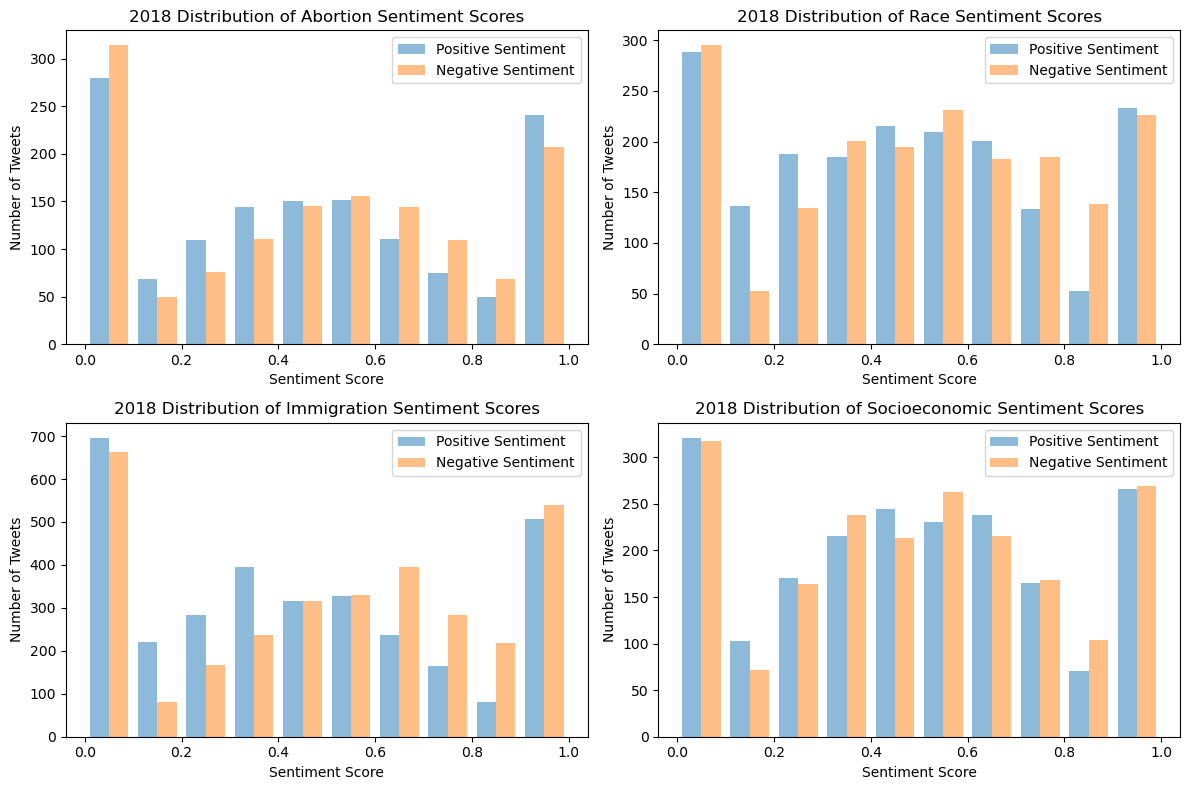

In [34]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histogram for abortion sentiment
axes[0, 0].hist([abortion_sent_2018['Norm_Pos'], abortion_sent_2018['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 0].set_xlabel('Sentiment Score')
axes[0, 0].set_ylabel('Number of Tweets')
axes[0, 0].set_title('2018 Distribution of Abortion Sentiment Scores')
axes[0, 0].legend()

# Plot histogram for race sentiment
axes[0, 1].hist([race_sent_2018['Norm_Pos'], race_sent_2018['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[0, 1].set_xlabel('Sentiment Score')
axes[0, 1].set_ylabel('Number of Tweets')
axes[0, 1].set_title('2018 Distribution of Race Sentiment Scores')
axes[0, 1].legend()

# Plot histogram for immigration sentiment
axes[1, 0].hist([immigration_sent_2018['Norm_Pos'], immigration_sent_2018['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 0].set_xlabel('Sentiment Score')
axes[1, 0].set_ylabel('Number of Tweets')
axes[1, 0].set_title('2018 Distribution of Immigration Sentiment Scores')
axes[1, 0].legend()

# Plot histogram for socioeconomic sentiment
axes[1, 1].hist([socio_sent_2018['Norm_Pos'], socio_sent_2018['Norm_Neg']], bins=10, alpha=0.5, label=['Positive Sentiment', 'Negative Sentiment'])
axes[1, 1].set_xlabel('Sentiment Score')
axes[1, 1].set_ylabel('Number of Tweets')
axes[1, 1].set_title('2018 Distribution of Socioeconomic Sentiment Scores')
axes[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Creating one table with all Bias group tags

In [35]:
data_2018
# gives 5410 rows

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN,NaN,NaN
1,2018,2018-12-01 06:26:11.0,CA,48243245,jimmydore miserablelib ronplacone im glad his ...,NaN,NaN,NaN,NaN
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice,NaN,job
3,2018,2018-12-01 17:28:54.0,IN,158216203,another aside from this davidmackau story im s...,NaN,NaN,NaN,NaN
4,2018,2018-12-01 21:41:00.0,CO,13241522,if we keep call bush a war criminal 19m hit on...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12647,2018,2018-11-30 06:35:58.0,OH,625159168,odppke when will you prosecute election tamper...,NaN,NaN,NaN,NaN
12648,2018,2018-11-30 13:07:29.0,GA,67097788,underhiswing914 thedjrichyb vabvox realdonaldt...,NaN,NaN,NaN,NaN
12650,2018,2018-11-30 18:22:23.0,CA,803988972061896704,johnsonkevinb cspanwj criminal regime this be ...,NaN,NaN,NaN,NaN
12651,2018,2018-11-30 20:23:40.0,CA,762782904669777920,orangecakemix realdonaldtrump the teflon queen...,NaN,NaN,NaN,NaN


In [36]:
# Remove rows with all NaN values in 'Abortion', 'Race', 'Immigration', and 'Socio_Eco' columns
data_2018_filtered = data_2018.dropna(subset=['Abortion', 'Race', 'Immigration', 'Socio_Eco'], how='all')

# Display the filtered DataFrame
print(data_2018_filtered)
# gives [6201 rows x 9 columns]

       Year                Created State               Owner   
0      2018  2018-12-01 01:00:48.0    OK           930134408  \
2      2018  2018-12-01 15:13:45.0    MI  948344223937515520   
8      2018  2018-12-02 16:39:10.0    FL           594050440   
9      2018  2018-12-02 18:18:02.0    TX  729745131918626817   
11     2018  2018-12-03 00:52:29.0    WA          2440550286   
...     ...                    ...   ...                 ...   
12637  2018  2018-11-29 01:38:27.0    OR           418394002   
12639  2018  2018-11-29 11:55:43.0    CT  823666081436942341   
12640  2018  2018-11-29 15:25:57.0    NY           258445244   
12646  2018  2018-11-30 04:01:21.0    CA            28649563   
12652  2018  2018-11-30 21:55:21.0    CA            33542748   

                                                   Tweet    Abortion   
0      so clearly the gop in oklahoma do not get the ...    abortion  \
2      deepstateexpose hellodolly and his job be just...         NaN   
8      kayleigh

In [37]:
# run Vader sentiment on All tweets
data_sent_2018 = get_sentiment_scores(data_2018_filtered)
data_sent_2018
# gives 6201 rows × 10 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\3555041138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\3555041138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu', 'compound']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN,NaN,NaN,"{'neg': 0.0, 'pos': 0.186}"
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice,NaN,job,"{'neg': 0.156, 'pos': 0.15}"
8,2018,2018-12-02 16:39:10.0,FL,594050440,kayleighmcenany realdonaldtrump dailycaller th...,NaN,NaN,border,NaN,"{'neg': 0.047, 'pos': 0.186}"
9,2018,2018-12-02 18:18:02.0,TX,729745131918626817,thetrumptrain i think we have a real voting in...,NaN,NaN,illegal,NaN,"{'neg': 0.316, 'pos': 0.049}"
11,2018,2018-12-03 00:52:29.0,WA,2440550286,fairimmigration let start with make trump sit ...,NaN,NaN,control,NaN,"{'neg': 0.19, 'pos': 0.063}"
...,...,...,...,...,...,...,...,...,...,...
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,right,civil,NaN,NaN,"{'neg': 0.377, 'pos': 0.0}"
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,healthcare,NaN,border,healthcare,"{'neg': 0.09, 'pos': 0.241}"
12640,2018,2018-11-29 15:25:57.0,NY,258445244,melankoly cnnpolitics the same dirty trickster...,NaN,minority,NaN,NaN,"{'neg': 0.127, 'pos': 0.348}"
12646,2018,2018-11-30 04:01:21.0,CA,28649563,tedlieu realdonaldtrump because he a pathologi...,NaN,NaN,control,NaN,"{'neg': 0.205, 'pos': 0.0}"


In [38]:
# Extract the sentiment scores from the 'SentimentScores' column
data_sent_2018['Norm_Neg'] = data_sent_2018['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2018['Norm_Pos'] = data_sent_2018['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
data_sent_2018
# gives 6201 rows × 10 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\86966488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2018['Norm_Neg'] = data_sent_2018['SentimentScores'].apply(lambda x: x['neg'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 0 else 0)
C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\86966488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sent_2018['Norm_Pos'] = data_sent_2018['SentimentScores'].apply(lambda x: x['pos'] / (x['neg'] + x['pos']) if (x['neg'] + x['pos']) != 

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,SentimentScores,Norm_Neg,Norm_Pos
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN,NaN,NaN,"{'neg': 0.0, 'pos': 0.186}",0.000000,1.000000
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice,NaN,job,"{'neg': 0.156, 'pos': 0.15}",0.509804,0.490196
8,2018,2018-12-02 16:39:10.0,FL,594050440,kayleighmcenany realdonaldtrump dailycaller th...,NaN,NaN,border,NaN,"{'neg': 0.047, 'pos': 0.186}",0.201717,0.798283
9,2018,2018-12-02 18:18:02.0,TX,729745131918626817,thetrumptrain i think we have a real voting in...,NaN,NaN,illegal,NaN,"{'neg': 0.316, 'pos': 0.049}",0.865753,0.134247
11,2018,2018-12-03 00:52:29.0,WA,2440550286,fairimmigration let start with make trump sit ...,NaN,NaN,control,NaN,"{'neg': 0.19, 'pos': 0.063}",0.750988,0.249012
...,...,...,...,...,...,...,...,...,...,...,...,...
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,right,civil,NaN,NaN,"{'neg': 0.377, 'pos': 0.0}",1.000000,0.000000
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,healthcare,NaN,border,healthcare,"{'neg': 0.09, 'pos': 0.241}",0.271903,0.728097
12640,2018,2018-11-29 15:25:57.0,NY,258445244,melankoly cnnpolitics the same dirty trickster...,NaN,minority,NaN,NaN,"{'neg': 0.127, 'pos': 0.348}",0.267368,0.732632
12646,2018,2018-11-30 04:01:21.0,CA,28649563,tedlieu realdonaldtrump because he a pathologi...,NaN,NaN,control,NaN,"{'neg': 0.205, 'pos': 0.0}",1.000000,0.000000


In [39]:
# This function only gets the compound sentiment
def get_compound_sentiment(df):
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
        # Create a new column for sentiment scores
    df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
    
    # Remove the 'neu' column from the SentimentScores column
    df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})
    
    return df

In [40]:
# run Vader sentiment on All tweets
data_all_sent_2018 = get_compound_sentiment(data_2018_filtered)
# Drop Sentiment Scores column
data_all_sent_2018 = data_all_sent_2018.drop(['SentimentScores'], axis=1)
data_all_sent_2018
# gives 6201 rows × 12 columns

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\406677615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SentimentScores'] = df['Tweet'].apply(lambda tweet: sia.polarity_scores(tweet))
C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\406677615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Compound'] = df['SentimentScores'].apply(lambda scores: {k: v for k, v in scores.items() if k not in ['neu','pos','neg']})


,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN,NaN,NaN,0.000000,1.000000,{'compound': 0.6697}
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice,NaN,job,0.509804,0.490196,{'compound': -0.0516}
8,2018,2018-12-02 16:39:10.0,FL,594050440,kayleighmcenany realdonaldtrump dailycaller th...,NaN,NaN,border,NaN,0.201717,0.798283,{'compound': 0.8537}
9,2018,2018-12-02 18:18:02.0,TX,729745131918626817,thetrumptrain i think we have a real voting in...,NaN,NaN,illegal,NaN,0.865753,0.134247,{'compound': -0.936}
11,2018,2018-12-03 00:52:29.0,WA,2440550286,fairimmigration let start with make trump sit ...,NaN,NaN,control,NaN,0.750988,0.249012,{'compound': -0.6615}
...,...,...,...,...,...,...,...,...,...,...,...,...
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,right,civil,NaN,NaN,1.000000,0.000000,{'compound': -0.9022}
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,healthcare,NaN,border,healthcare,0.271903,0.728097,{'compound': 0.8934}
12640,2018,2018-11-29 15:25:57.0,NY,258445244,melankoly cnnpolitics the same dirty trickster...,NaN,minority,NaN,NaN,0.267368,0.732632,{'compound': 0.9229}
12646,2018,2018-11-30 04:01:21.0,CA,28649563,tedlieu realdonaldtrump because he a pathologi...,NaN,NaN,control,NaN,1.000000,0.000000,{'compound': -0.7717}


## Final correct data frame to upload to postgresSQL

In [41]:
# Extract to compound value from the dictionary

# Update the "Compound" column
data_all_sent_2018['Compound'] = data_all_sent_2018['Compound'].apply(lambda x: x['compound'])

# Convert the "Compound" column to a numeric data type
data_all_sent_2018['Compound'] = pd.to_numeric(data_all_sent_2018['Compound'])

# Print the updated DataFrame
data_all_sent_2018
# gives 6201 rows × 12 columns

,Year,Created,State,Owner,Tweet,Abortion,Race,Immigration,Socio_Eco,Norm_Neg,Norm_Pos,Compound
0,2018,2018-12-01 01:00:48.0,OK,930134408,so clearly the gop in oklahoma do not get the ...,abortion,NaN,NaN,NaN,0.000000,1.000000,0.6697
2,2018,2018-12-01 15:13:45.0,MI,948344223937515520,deepstateexpose hellodolly and his job be just...,NaN,justice,NaN,job,0.509804,0.490196,-0.0516
8,2018,2018-12-02 16:39:10.0,FL,594050440,kayleighmcenany realdonaldtrump dailycaller th...,NaN,NaN,border,NaN,0.201717,0.798283,0.8537
9,2018,2018-12-02 18:18:02.0,TX,729745131918626817,thetrumptrain i think we have a real voting in...,NaN,NaN,illegal,NaN,0.865753,0.134247,-0.9360
11,2018,2018-12-03 00:52:29.0,WA,2440550286,fairimmigration let start with make trump sit ...,NaN,NaN,control,NaN,0.750988,0.249012,-0.6615
...,...,...,...,...,...,...,...,...,...,...,...,...
12637,2018,2018-11-29 01:38:27.0,OR,418394002,nycartistrosems kelly2277 this be just the jan...,right,civil,NaN,NaN,1.000000,0.000000,-0.9022
12639,2018,2018-11-29 11:55:43.0,CT,823666081436942341,realdonaldtrump where be that election promise...,healthcare,NaN,border,healthcare,0.271903,0.728097,0.8934
12640,2018,2018-11-29 15:25:57.0,NY,258445244,melankoly cnnpolitics the same dirty trickster...,NaN,minority,NaN,NaN,0.267368,0.732632,0.9229
12646,2018,2018-11-30 04:01:21.0,CA,28649563,tedlieu realdonaldtrump because he a pathologi...,NaN,NaN,control,NaN,1.000000,0.000000,-0.7717


## Load Sentiment table into PostGres
data_all_sent_2017: The single table that has all data

In [42]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    database=DATABASE,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Create a sqlalchemy engine
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

data_all_sent_2018.to_sql("twitter", engine, if_exists="append", index=False)
print("Twitter table loaded successfully")

# Commit the changes to the database
conn.commit()

# Close the database connection
conn.close()

Twitter table loaded successfully


## View the data

In [43]:
# Replace the values below with your database credentials
DATABASE = "sentimentdb"
USER = "postgres"
PASSWORD = "YourPassword"
HOST = "localhost"
PORT = "5432"

# Connect to the PostgreSQL database
conn = psycopg2.connect(database=DATABASE, user=USER, password=PASSWORD, host=HOST, port=PORT)

# Query the table and store the results in a Pandas dataframe
df = pd.read_sql_query("SELECT * FROM twitter", conn)

# Print the dataframe to verify that it contains data
print(df)

# Close the database connection
conn.close()
# gives [3164 rows x 12 columns] for 2016
# [5103 rows x 12 columns] for 2017 appended
# [11304 rows x 12 columns] for 2018 appended

       Year                Created State               Owner   
0      2016    2016-01-03 10:33:49    TX            14649308  \
1      2016    2016-01-04 16:23:26    NH            88940328   
2      2016     2016-01-05 7:13:04    VA           359716229   
3      2016     2016-01-06 2:52:22    AZ            67238855   
4      2016    2016-01-06 15:27:19    NY            49698134   
...     ...                    ...   ...                 ...   
11299  2018  2018-11-29 01:38:27.0    OR           418394002   
11300  2018  2018-11-29 11:55:43.0    CT  823666081436942341   
11301  2018  2018-11-29 15:25:57.0    NY           258445244   
11302  2018  2018-11-30 04:01:21.0    CA            28649563   
11303  2018  2018-11-30 21:55:21.0    CA            33542748   

                                                   Tweet    Abortion   
0      deep convos after midtown about black life mat...        None  \
1      president bill clinton say this election will ...        None   
2      we need 

C:\Users\Owner\AppData\Local\Temp\ipykernel_10936\665317939.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM twitter", conn)
